In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# themes and appearance
sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_colwidth', 400)

In [2]:
# import data

# training data
df_train = pd.read_pickle('data/df_clean.pickle')[['song', 'artist', 'chord_progression_C']].rename({'chord_progression_C': 'chord_progression'}, axis=1)
df_train = df_train[df_train.chord_progression.apply(len) > 1].reset_index(drop=True)
len_dataset = df_train.shape[0]

# data predicted from transformer models
df_m1k = pd.read_pickle('data/df_m1k.pickle').iloc[0:len_dataset].reset_index(drop=True)
df_m10k = pd.read_pickle('data/df_m10k.pickle').iloc[0:len_dataset].reset_index(drop=True)
df_m4 = pd.read_pickle('data/df_m4.pickle').iloc[0:len_dataset].reset_index(drop=True)
df_m4u = pd.read_pickle('data/df_m4u.pickle').iloc[0:len_dataset].reset_index(drop=True)

In [3]:
def top_progressions(dataframe, name='', n=1000):
    df = pd.DataFrame(dataframe.chord_progression.astype('str').value_counts().head(n)).reset_index()
    df['chord_progression'] = df['chord_progression'].replace("['\[\],]", '', regex=True)
    return df.rename({'count': f'{name}'}, axis=1)


In [4]:
def combine_counts():
    df = top_progressions(df_train, 'train_counts')
    
    df1 = top_progressions(df_m1k, 'm1k_counts')
    df2 = top_progressions(df_m10k, 'm10k_counts')
    df3 = top_progressions(df_m4, 'm4_counts')
    df4 = top_progressions(df_m4u, 'm4u_counts')
    
    for d in [df1, df2, df3, df4]:
        df = pd.merge(df, d, on='chord_progression', how='outer')
    
    numeric_columns = [x for x in df.columns if x != 'chord_progression']
    df[numeric_columns] = df[numeric_columns].astype('Int64')
    df['total_counts'] = df[numeric_columns].sum(axis=1)
    
    return df.sort_values('total_counts', ascending=False).reset_index(drop=True)


In [5]:
# top chord progressions by method
progression_counts = combine_counts().drop('total_counts', axis=1).fillna(0).head(50)
progression_counts

,chord_progression,train_counts,m1k_counts,m10k_counts,m4_counts,m4u_counts
0,C G Am F,424,565,673,434,243
1,Am F C G,430,440,482,531,264
2,F C G,316,359,255,341,415
3,F G C,201,279,214,258,253
4,G F C,203,276,229,250,188
5,F C G Am,244,219,283,262,124
6,C F,222,233,270,241,166
7,C G F,193,226,221,214,208
8,Am F G,148,242,146,191,327
9,C F G,160,206,154,236,225


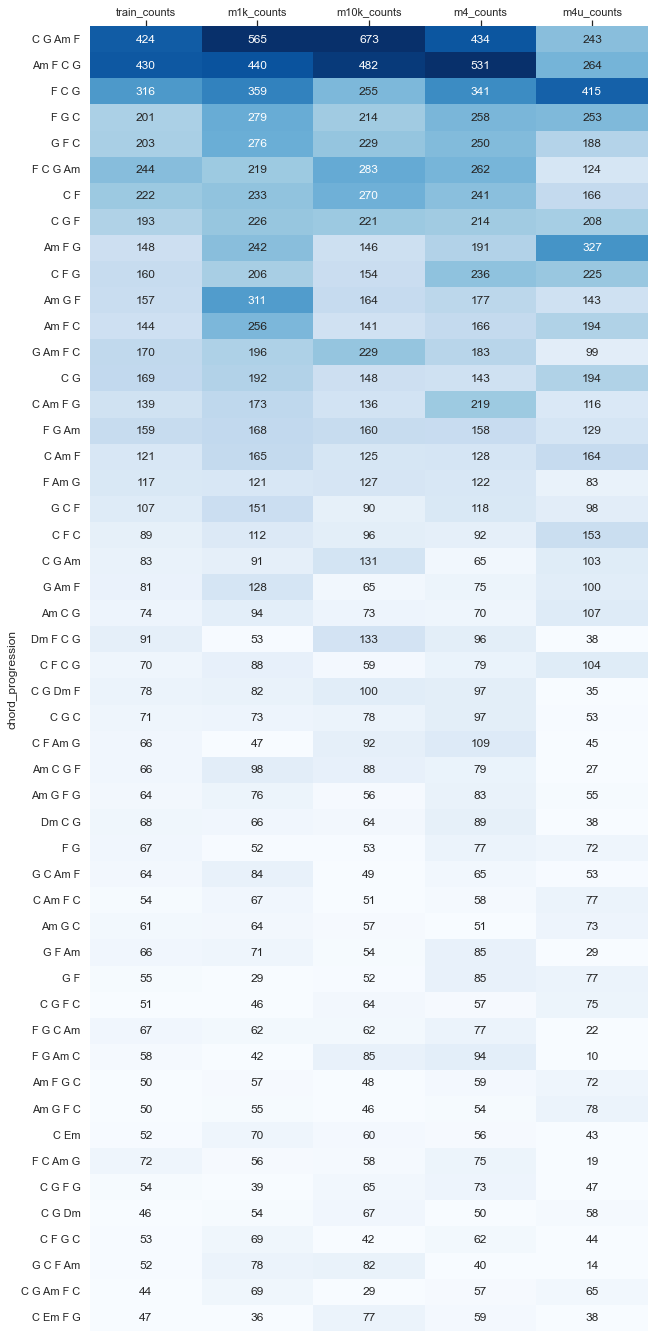

In [6]:
# plot as a heatmap
plt.figure(figsize=(10, 24))
fig = sns.heatmap(progression_counts.set_index('chord_progression').astype(float), cmap='Blues', annot=True, fmt='g', cbar=False, vmin=50, vmax=500)
fig.xaxis.tick_top()
plt.show()